# Prerequisites

### Download the model
You may download the [Luxical One model weights from HuggingFace](https://huggingface.co/DatologyAI/luxical-one/resolve/main/luxical_one_rc4.npz).

### Sync the dev dependencies
From the root of the repository, run `just setup-dev` (you will need the command-runner `just` installed. You may also directly run the command from the `justfile`).

In [1]:
import re
import time
from multiprocessing import cpu_count
from pathlib import Path
from tempfile import TemporaryDirectory

import fasttext
import pandas as pd
import numpy as np
from datasets import load_dataset
from numpy.typing import NDArray
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from tqdm.auto import tqdm

from luxical.embedder import Embedder
from luxical.misc_utils import (
    fast_8bit_uniform_scalar_quantize,
    dequantize_8bit_uniform_scalar_quantized,
)

# Evaluation: Fitting the FineWeb EDU Annotations

In [2]:
%%time
# Load the dataset and perform a stratified train-test split of 10% of the data using random state 42.
dataset = load_dataset("HuggingFaceFW/fineweb-edu-llama3-annotations", split="train")
df_dataset = dataset.to_pandas()
texts = df_dataset["text"].tolist()
scores = df_dataset["score"].to_numpy()
text_train, text_test, score_train, score_test = train_test_split(
    texts,
    scores,
    test_size=0.1,
    random_state=42,
    stratify=scores,
)

# Create a binary classification task of predicting high quality examples (3+ stars, aka the top ~9% of examples).
y_binary_test = np.asarray(score_test) >= 3
y_binary_train = np.asarray(score_train) >= 3

CPU times: user 1.3 s, sys: 1.21 s, total: 2.51 s
Wall time: 3.79 s


# Baseline: FastText classification

In [3]:
def fasttext_normalize_text(text):
    # NOTE: FTFY is really slow, so we skip it here.
    # text = ftfy.fix_text(text, config=FTFT_CONFIG)
    text = re.sub(r"\r?\n", f" {'<NEW_LINE>'} ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip().lower()
    return text


def write_training_data(texts: list[str], labels: NDArray[np.bool_], path: str | Path):
    line_iter = (
        f"__label__{int(label)} {fasttext_normalize_text(text)}\n"
        for text, label in zip(texts, labels)
    )
    line_iter = tqdm(line_iter, total=len(texts), unit="text", unit_scale=True)
    with Path(path).open("w") as f:
        f.writelines(line_iter)


def predict_ft(ft_model, text_list: list[str]):
    text_list = [
        fasttext_normalize_text(text)
        for text in tqdm(
            text_list,
            desc="Normalizing for FastText prediction",
            unit="text",
            unit_scale=True,
        )
    ]
    pred_labels, pred_scores = ft_model.predict(text_list, k=10)
    res = np.zeros(len(text_list))
    for i, (labels, scores) in enumerate(zip(pred_labels, pred_scores)):
        label_ints = np.asarray([int(s.removeprefix("__label__")) for s in labels])
        scalar_label = np.dot(scores, label_ints.astype(np.float32))
        res[i] = scalar_label
    return res

In [4]:
%%time
# Train a fasttext model using hand-tuned hyperparameters.
# (You can also try the auto-tuning feature, but my results were not good.)
with TemporaryDirectory() as tmp_dir:
    fasttext_training_data_path = Path(tmp_dir) / "fasttext_training_data.txt"
    print(f"Writing FastText training data to {fasttext_training_data_path}")
    write_training_data(text_train, y_binary_train, fasttext_training_data_path)
    print("Training FastText model...")
    ft_model = fasttext.train_supervised(
        input=str(fasttext_training_data_path),
        epoch=10,
        lr=0.1,
        wordNgrams=2,
        minCount=1,
        loss="hs",
        thread=cpu_count(),
    )

Writing FastText training data to /var/folders/qb/p74wc0ys2b97hg4p4my_8jnc0000gn/T/tmp1ktypm87/fasttext_training_data.txt


  0%|          | 0.00/421k [00:00<?, ?text/s]

Training FastText model...


Read 255M words
Number of words:  3548345
Number of labels: 2
Progress: 100.0% words/sec/thread: 3754509 lr:  0.000000 avg.loss:  0.137561 ETA:   0h 0m 0s


CPU times: user 11min 20s, sys: 10 s, total: 11min 30s
Wall time: 1min 33s


In [5]:
%%time
# Evaluate the fasttext model.
y_hat_ft = predict_ft(ft_model, text_test)
print(f"FastText AUC: {roc_auc_score(y_binary_test, y_hat_ft):.4f}")

Normalizing for FastText prediction:   0%|          | 0.00/46.7k [00:00<?, ?text/s]

FastText AUC: 0.9393
CPU times: user 8.2 s, sys: 240 ms, total: 8.44 s
Wall time: 8.41 s


# Luxical: Lexical Embeddings At Lightspeed

In [6]:
%%time
# Load the model.
print("Loading model...")
embedder = Embedder.load(Path.home() / "Downloads" / "luxical_one_rc4.npz")

# Run once to JIT compile the embedding functions.
print("Triggering JIT compile of embedding function...")
emb = embedder(["Hello, world!"])
print(f"NOTE: Our embedding dimensionality is {emb.shape[1]}")

Loading model...
Triggering JIT compile of embedding function...
NOTE: Our embedding dimensionality is 192
CPU times: user 2.16 s, sys: 192 ms, total: 2.35 s
Wall time: 2.42 s


In [7]:
%%time
# Embed the texts.
emb_train = embedder(text_train, progress_bars=True)
emb_test = embedder(text_test, progress_bars=True)

Embedding:   0%|          | 0.00/421k [00:00<?, ?text/s]

0.00token [00:00, ?token/s]

Embedding:   0%|          | 0.00/46.7k [00:00<?, ?text/s]

0.00token [00:00, ?token/s]

CPU times: user 14min 18s, sys: 13.8 s, total: 14min 31s
Wall time: 1min 8s


In [8]:
%%time
# Round-trip through quantization.
quantization_limit = 0.5
emb_train_quant = fast_8bit_uniform_scalar_quantize(emb_train, quantization_limit)
emb_test_quant = fast_8bit_uniform_scalar_quantize(emb_test, quantization_limit)
emb_train = dequantize_8bit_uniform_scalar_quantized(
    emb_train_quant, quantization_limit
)
emb_test = dequantize_8bit_uniform_scalar_quantized(emb_test_quant, quantization_limit)

f"Embeddings of the {emb_train.shape[0]:,} training docs fit into {len(emb_train_quant.tobytes()) / 2**20:,.2f}MiB"

CPU times: user 258 ms, sys: 132 ms, total: 390 ms
Wall time: 279 ms


'Embeddings of the 420,681 training docs fit into 77.03MiB'

In [9]:
# Define a utility function for evaluating a model's AUC.
def eval_model_auc(model, emb_train, y_train, emb_test, y_test) -> float:
    # Filter numpy matmul warnings since they seem to be hair-trigger on some systems.
    with np.testing.suppress_warnings() as sup:
        sup.filter(RuntimeWarning, message=r".*encountered in matmul.*")
        train_start = time.time()
        model.fit(emb_train, y_train)
        train_runtime = time.time() - train_start
        print(f"Trained in {train_runtime:.4f}s")
        pred_start = time.time()
        y_hat = model.predict_proba(emb_test)[:, 1]
        pred_runtime = time.time() - pred_start
        pred_throughput = len(y_hat) / pred_runtime
        print(
            f"Test-set inference in {pred_runtime:.4f}s ({pred_throughput:,.0f} row/s)"
        )
    return float(roc_auc_score(y_test, y_hat))

In [10]:
# Train and evaluate logistic regression classifier on top of Luxical embeddings.
logistic_regression_no_l2_penalty = LogisticRegression(max_iter=1_000, C=1_000)
auc_logreg = eval_model_auc(
    logistic_regression_no_l2_penalty,
    emb_train,
    y_binary_train,
    emb_test,
    y_binary_test,
)
print(f"LogReg AUC: {auc_logreg:.4f}")

Trained in 0.5872s
Test-set inference in 0.0061s (7,661,665 row/s)
LogReg AUC: 0.9391


In [11]:
# Train and evaluate a tiny 2-layer MLP classifier on top of Luxical embeddings.
# Scikit-learn has very out-of-date defaults for training MLPs, so we adjust.
mlp_two_layer_two_epoch = MLPClassifier(
    hidden_layer_sizes=(256, 256),
    random_state=0,
    max_iter=2,  # Two epochs
    alpha=0.0,  # No L2 penalty
    learning_rate="constant",  # Simple learning rate schedule
    learning_rate_init=3e-3,  # High learning rate for small model
    batch_size=1024,  # Go bigger than the default of 200, which is inefficient.
)
auc_mlp = eval_model_auc(
    mlp_two_layer_two_epoch,
    emb_train,
    y_binary_train,
    emb_test,
    y_binary_test,
)
print(f"MLP AUC: {auc_mlp:.4f}")

Trained in 1.9968s
Test-set inference in 0.0167s (2,797,499 row/s)
MLP AUC: 0.9515


/Users/luke/code/luxical/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(


# Appendix: Measuring Throughput

Byte length stats:
count    100000.000000
mean       3582.787310
std        4682.029649
min         162.000000
25%        1211.000000
50%        2362.000000
75%        4286.000000
max      317343.000000
dtype: float64
Total bytes of input text: 341.68MiB


Text(0.5, 1.0, 'Byte length of throughput testing texts')

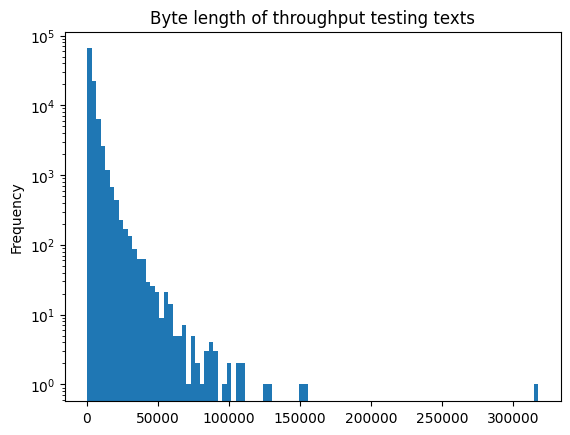

In [12]:
# Create a batch of inputs to test on.
sample_size = 100_000
text_sample = [texts[i] for i in np.random.permutation(len(texts))[:sample_size]]

# Measure the input size in bytes of utf8.
byte_lengths = pd.Series([len(s.encode("utf-8")) for s in text_sample])

print(f"Byte length stats:\n{byte_lengths.describe()}")
ax = byte_lengths.plot.hist(bins=100, logy=True)
print(f"Total bytes of input text: {byte_lengths.sum() / (2**20):,.2f}MiB")
ax.set_title("Byte length of throughput testing texts")

### Embedding

In [13]:
%%timeit
_ = embedder(text_sample)

14.7 s ± 436 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### FastText

In [14]:
%%timeit
for text in text_sample:
    fasttext_normalize_text(text)

8.84 s ± 50.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
ft_normalized_text_sample = [fasttext_normalize_text(text) for text in text_sample]

In [16]:
%%timeit
_ = ft_model.predict(ft_normalized_text_sample, k=2)

9.05 s ± 148 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### MLP inference

In [17]:
embedding_sample = embedder(text_sample)

In [18]:
%%timeit
with np.testing.suppress_warnings() as sup:
    sup.filter(RuntimeWarning, message=r".*encountered in matmul.*")
    _ = mlp_two_layer_two_epoch.predict_proba(embedding_sample)

34 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
